<a href="https://colab.research.google.com/github/ArtyomShabunin/SMOPA-25/blob/main/lesson_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://prana-system.com/files/110/rds_color_full.png" alt="tot image" width="300"  align="center"/> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<img src="https://mpei.ru/AboutUniverse/OficialInfo/Attributes/PublishingImages/logo1.jpg" alt="mpei image" width="200" align="center"/>
<img src="https://mpei.ru/Structure/Universe/tanpe/structure/tfhe/PublishingImages/tot.png" alt="tot image" width="100"  align="center"/>

---

# **Системы машинного обучения и предиктивной аналитики в тепловой и возобновляемой энергетике**  

# ***Практические занятия***


---

# Занятие №8
# Прогнозирование временных рядов методами машинного обучения
**9 апреля 2025г.**

---

**Временной ряд** — это последовательность числовых данных, упорядоченных во времени и собранных через **равные промежутки времени**.

**Примеры временных рядов:**
- Температура воздуха каждый час
- Цена на нефть каждый день
- Электрическая мощность установки каждую секунду
- Количество клиентов в магазине каждый день
- Давление в котле каждые 10 секунд

---

**Особенности временных рядов:**

1. **Время имеет значение** — порядок данных важен, в отличие от обычных таблиц.
2. **Зависимость от прошлого** — текущее значение может зависеть от предыдущих (автокорреляция).
3. **Стационарность или нестационарность** — поведение ряда может меняться со временем (например, тренд, изменение дисперсии).
4. **Сезонность** — повторяющиеся циклы (день-ночь, зима-лето и т.д.).

---

**Где используются:**

- Финансы (курсы акций, криптовалюты)
- Энергетика (нагрузка, температура, давление)
- Промышленность (сигналы с датчиков)
- Метеорология (погода, климат)
- Медицина (ЭКГ, пульс, мониторинг пациентов)
- Транспорт (потоки, GPS-координаты)

---

**Задача предсказания временных рядов** — это тип задачи машинного обучения или статистического анализа, в которой требуется спрогнозировать будущие значения некоторой переменной на основе её предыдущих наблюдений, упорядоченных во времени.

**Пример:**
Допустим, у нас есть данные о температуре каждый день за последние 30 дней. Мы хотим предсказать температуру на следующий день. Это и есть задача предсказания временного ряда.

**Типы задач:**
- **Одношаговое предсказание (one-step forecasting)** — предсказание значения на следующий момент времени.
- **Многопериодное предсказание (multi-step forecasting)** — предсказание значений на несколько будущих шагов.
- **Унивариантное (univariate)** — используется только один временной ряд.
- **Мультивариантное (multivariate)** — используются несколько временных рядов (например, температура, давление и влажность одновременно).

In [199]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Загрузка данных и обработка данных
Набор содержит данные о почасовом производстве ветряной и солнечной электроэнергии (в МВт) во французской электросети с 2020 года.

In [200]:
import gdown
import warnings
warnings.filterwarnings('ignore')
gdown.download('https://drive.google.com/uc?id=1NAYPaEkovk7jvaURdjI0nCi7CUMxry7W', verify=False)

df = pd.read_csv('./intermittent-renewables-production-france.csv')

Downloading...
From: https://drive.google.com/uc?id=1NAYPaEkovk7jvaURdjI0nCi7CUMxry7W
To: /content/intermittent-renewables-production-france.csv
100%|██████████| 5.12M/5.12M [00:00<00:00, 66.2MB/s]


In [201]:
df.head()

,Date and Hour,Date,StartHour,EndHour,Source,Production,dayOfYear,dayName,monthName
0,2020-07-22 20:00:00+02:00,2020-07-22,20:00:00,21:00:00,Solar,244.0,204,Wednesday,July
1,2020-07-23 07:00:00+02:00,2020-07-23,07:00:00,08:00:00,Solar,223.0,205,Thursday,July
2,2020-07-23 16:00:00+02:00,2020-07-23,16:00:00,17:00:00,Solar,2517.0,205,Thursday,July
3,2020-07-23 19:00:00+02:00,2020-07-23,19:00:00,20:00:00,Solar,658.0,205,Thursday,July
4,2020-07-23 23:00:00+02:00,2020-07-23,23:00:00,24:00:00,Solar,0.0,205,Thursday,July


In [202]:
df = df.rename(columns={'Date and Hour' : 'DateTime'})
df['DateTime'] = df['DateTime'].str.slice(stop=-6)
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.sort_values(ascending=True,by='DateTime')
df = df.drop(['Date','dayOfYear','dayName','monthName'],axis=1)
df = df.dropna()
df = df.set_index("DateTime")

In [203]:
df.head()

,StartHour,EndHour,Source,Production
DateTime,,,,
2020-01-01 00:00:00,00:00:00,01:00:00,Solar,0.0
2020-01-01 00:00:00,00:00:00,01:00:00,Wind,3549.0
2020-01-01 01:00:00,01:00:00,02:00:00,Solar,0.0
2020-01-01 01:00:00,01:00:00,02:00:00,Wind,2952.0
2020-01-01 02:00:00,02:00:00,03:00:00,Solar,0.0


In [204]:
solar = df[df['Source'] == 'Solar']['Production']
wind = df[df['Source'] == 'Wind']['Production']

In [205]:
solar, wind

(DateTime
 2020-01-01 00:00:00       0.0
 2020-01-01 01:00:00       0.0
 2020-01-01 02:00:00       0.0
 2020-01-01 03:00:00       0.0
 2020-01-01 04:00:00       0.0
                         ...  
 2023-06-30 19:00:00    1273.0
 2023-06-30 20:00:00     439.0
 2023-06-30 21:00:00      50.0
 2023-06-30 22:00:00       1.0
 2023-06-30 23:00:00       1.0
 Name: Production, Length: 29901, dtype: float64,
 DateTime
 2020-01-01 00:00:00    3549.0
 2020-01-01 01:00:00    2952.0
 2020-01-01 02:00:00    2722.0
 2020-01-01 03:00:00    2753.0
 2020-01-01 04:00:00    2707.0
                         ...  
 2023-06-30 19:00:00    5742.0
 2023-06-30 20:00:00    5152.0
 2023-06-30 21:00:00    4857.0
 2023-06-30 22:00:00    5140.0
 2023-06-30 23:00:00    6135.0
 Name: Production, Length: 29903, dtype: float64)

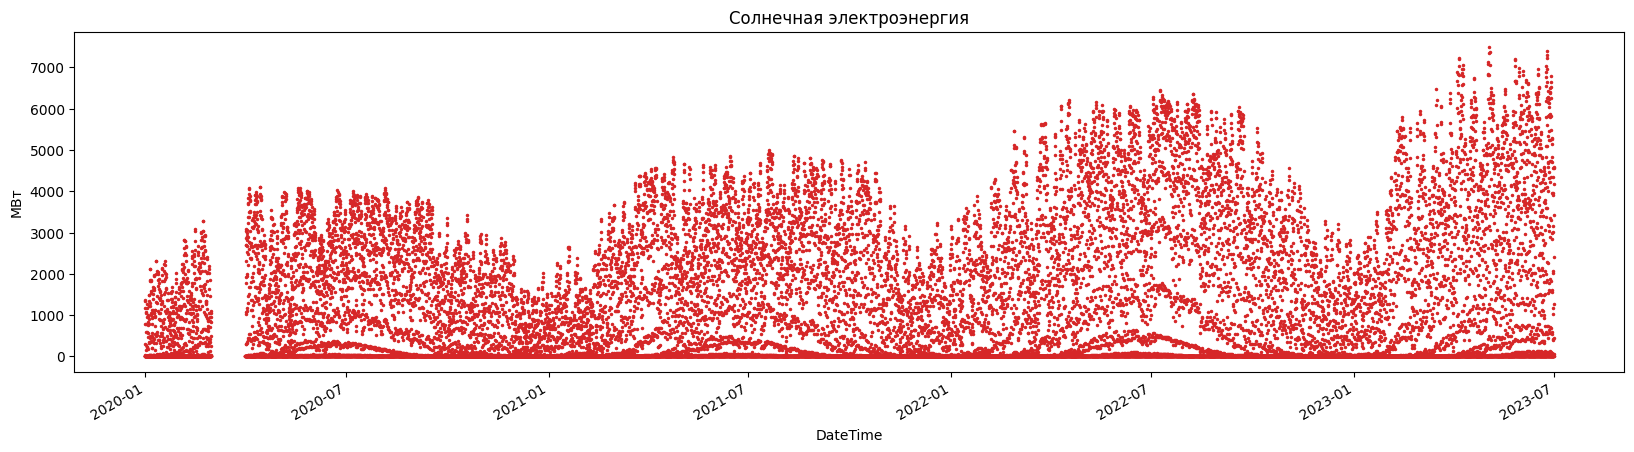

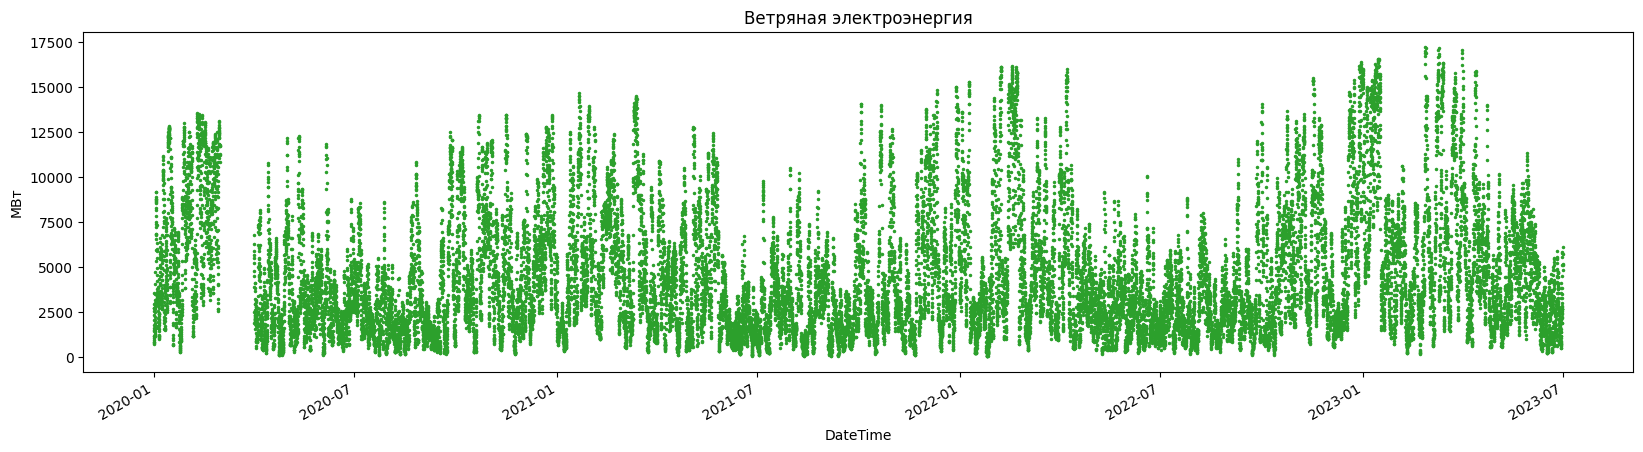

In [206]:
color_pal = sns.color_palette()
solar.plot(style='.',
          figsize=(20, 5),
          ms=3,
          color=color_pal[3],
          title='Солнечная электроэнергия')
plt.ylabel("МВт")
plt.show()

wind.plot(style='.',
          figsize=(20, 5),
          ms=3,
          color=color_pal[2],
          title='Ветряная электроэнергия')
plt.ylabel("МВт")
plt.show()

## Производство солнечной электроэнергии
### Разложение временного ряда

**Разложение временного ряда** — это метод, при котором временной ряд представляется как сумма (или произведение) нескольких более простых компонент:

1. **Тренд (`trend`)** — общее направление изменения данных с течением времени. Это может быть рост, спад или стабилизация.
2. **Сезонность (`seasonal`)** — периодические колебания, которые повторяются через равные интервалы времени (например, дни недели, месяцы, сезоны года).
3. **Остаток (`residual` или `noise`)** — всё, что не объясняется трендом и сезонностью. Это случайные, непредсказуемые флуктуации.

<img src="https://github.com/ArtyomShabunin/SMOPA-25/blob/main/imgs/trend_seasonality.png?raw=true" alt="trend_seasonality" width="800"  align="center"/>
* картинка из конспекта лекции Воронцова В.К. Методы машинного обучения. Инкрементное и онлайн обучение. ВМК МГУ 2022

- **Ряд 1** - сезонность без тренда
- **Ряд 2** - линейный тренд, аддитивная сезоность
- **Ряд 3** - линейный тренд, мультипликативная сезонность
- **Ряд 4** - экспоненциальный тренд, мультипликативная сезонность

---

**Математические модели**

Есть два основных способа описания этих компонентов:

1. **Аддитивная модель** (additive model)
Предполагает, что все компоненты **независимы друг от друга** и просто **суммируются**:

$$Y_t = T_t + S_t + R_t$$

Где:
- $ Y_t $ — наблюдаемое значение временного ряда в момент времени \( t \)
- $ T_t $ — тренд
- $ S_t $ — сезонная компонента
- $ R_t $ — остаток (шум)

**Когда использовать**: когда амплитуда сезонных колебаний **постоянна**, независимо от уровня тренда.

---

2. **Мультипликативная модель** (multiplicative model)

Предполагает, что компоненты взаимодействуют **мультипликативно**:

$$Y_t = T_t \times S_t \times R_t$$

**Когда использовать**: когда сезонные колебания **усиливаются или ослабевают** вместе с ростом тренда (например, расходы растут и колебания становятся больше по мере роста доходов компании).

---

**Что даёт разложение?**

1. **Анализ структуры ряда** — можно отдельно рассмотреть, какие сезонные эффекты присутствуют, каков общий тренд.
2. **Предобработка для прогнозирования** — если удалить сезонность и тренд, можно подавать чистые остатки на модель.
3. **Детекция аномалий** — если резидуальная компонента аномально большая, можно предположить сбой или событие.

In [207]:
from statsmodels.tsa.seasonal import seasonal_decompose

def seasonal_decompose_plotter(
    df: pd.DataFrame, model='additive',
    period=12, title='', figsize=(20, 12)):

    # period - период сезонности

    decomposition = seasonal_decompose(df.values, model=model, period=period)
    de_season = decomposition.seasonal
    de_resid = decomposition.resid
    de_trend = decomposition.trend

    fig, ax = plt.subplots(4, sharex=True, figsize=figsize)

    ax[0].set_title(title)
    ax[0].plot(df.index, df.values, color='C3')
    ax[0].set_ylabel(df.keys()[0])
    ax[0].grid(alpha=0.25)

    ax[1].plot(df.index, de_trend, color='C1')
    ax[1].set_ylabel('Trend')
    ax[1].grid(alpha=0.25)

    ax[2].plot(df.index, de_season, color='C2')
    ax[2].set_ylabel('Seasonal')
    ax[2].grid(alpha=0.25)

    ax[3].axhline(y=0, color='k', linewidth=1)
    ax[3].scatter(df.index, de_resid, color='C0', s=10)
    ax[3].set_ylabel('Resid')
    ax[3].grid(alpha=0.25)

    plt.tight_layout(h_pad=0)
    plt.show()

    return decomposition

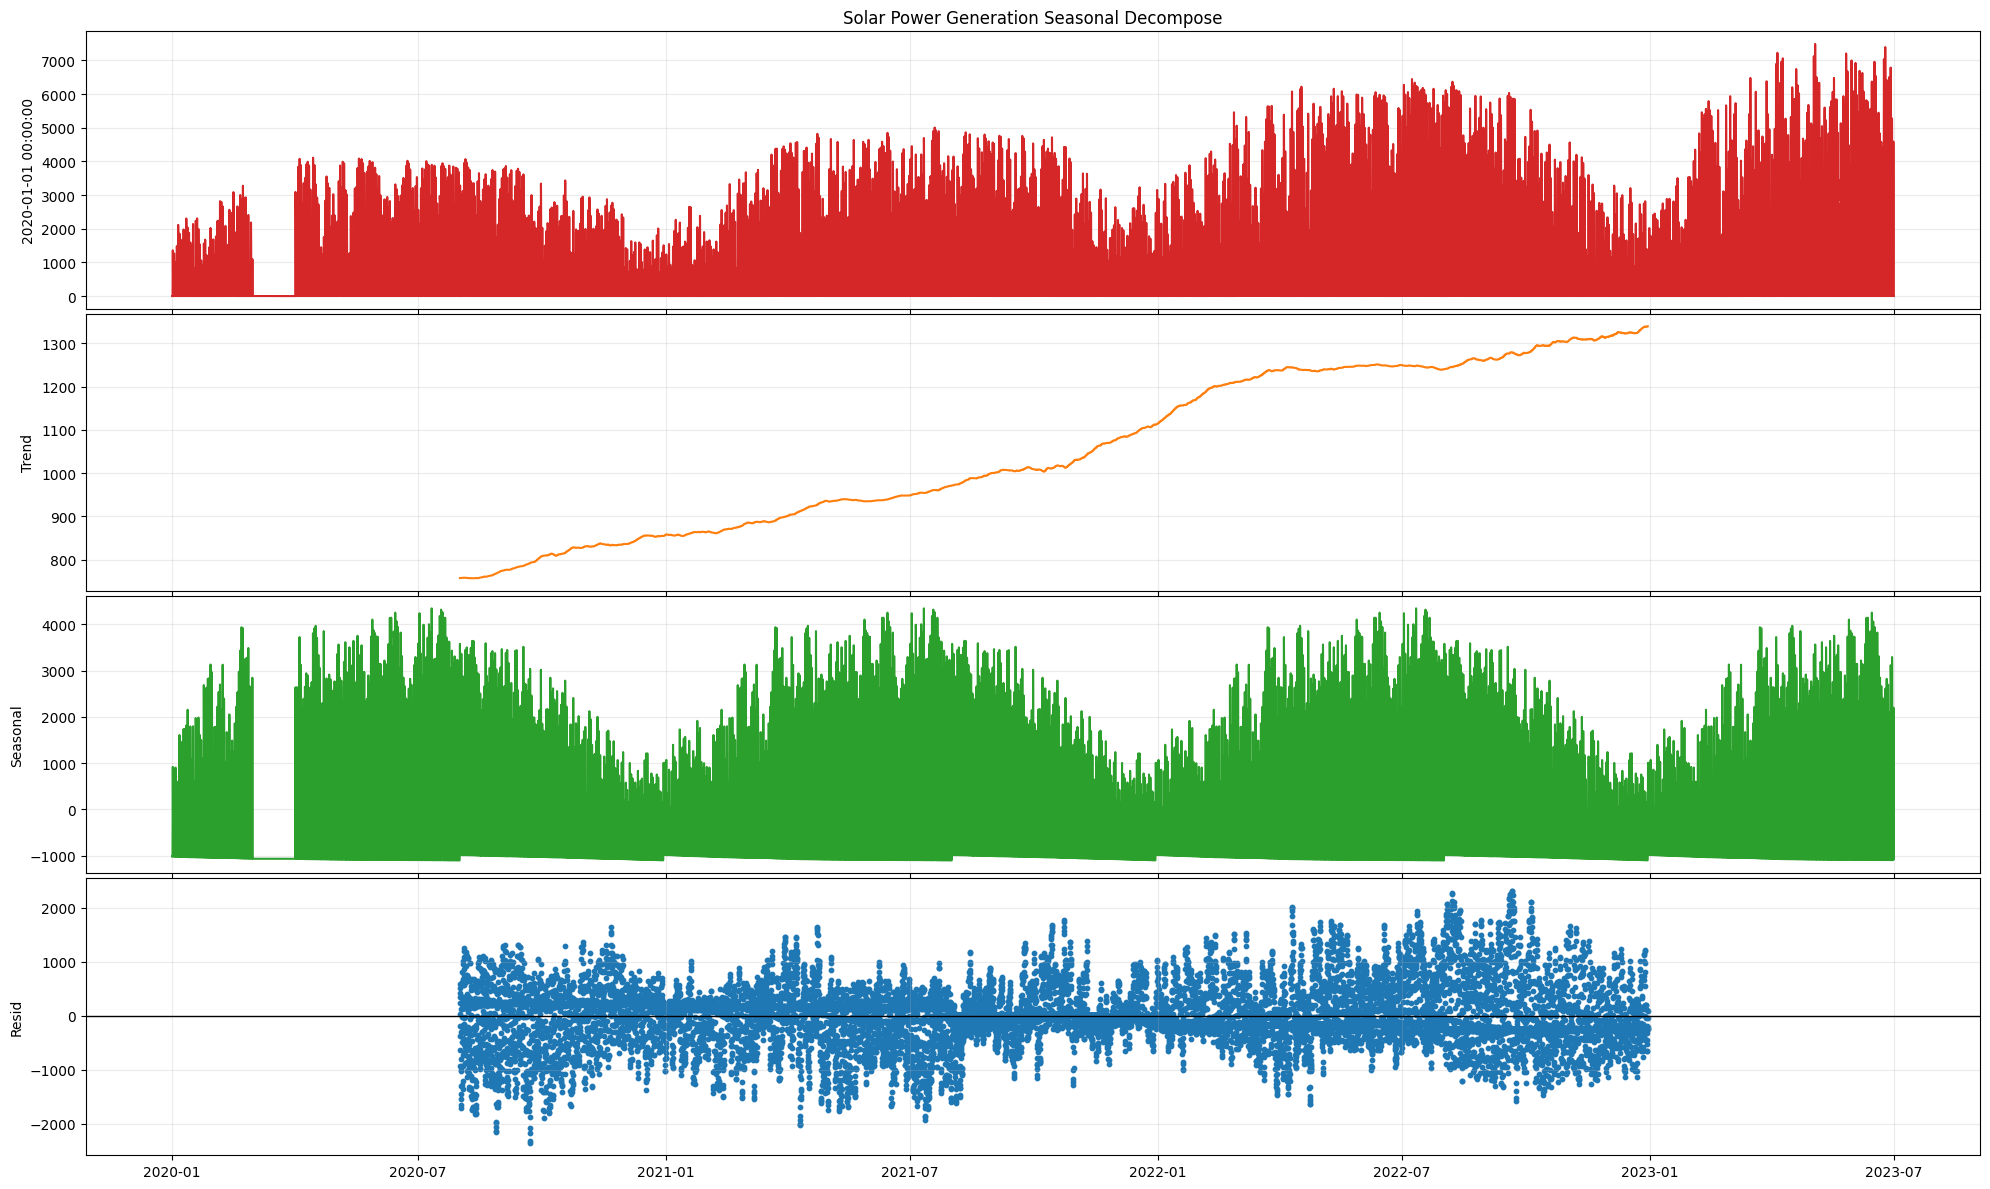

In [208]:
_ = seasonal_decompose_plotter(
    solar, model='additive', period=24*365,
    title='Solar Power Generation Seasonal Decompose', figsize=(20, 12))

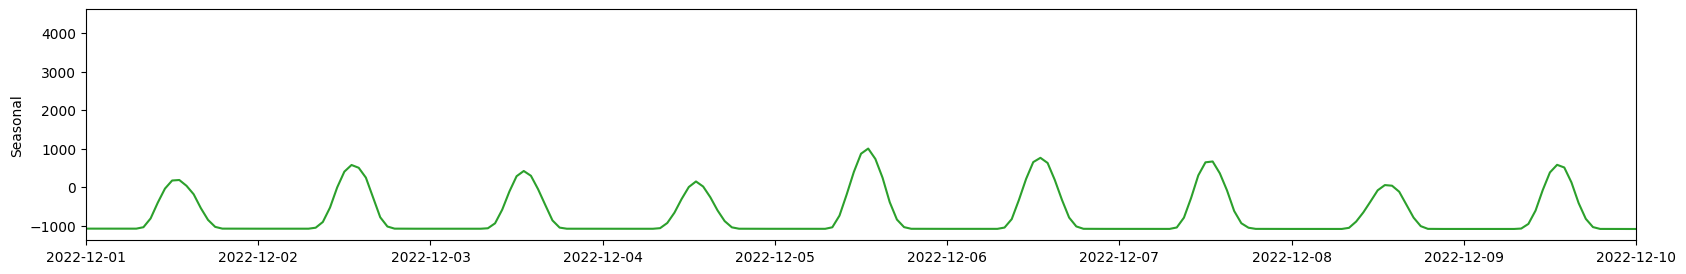

In [209]:
fig = plt.figure(figsize=(20, 3));
plt.plot(solar.index, _.seasonal, color='C2');
plt.ylabel('Seasonal');
plt.xlim(pd.to_datetime(['2022-12-01', '2022-12-10']));

### Предсказание производства солнечной электроэнергии, на осредненных данных

Для упрощения выполним агрегацию временного ряда с переходом от почасовой к суточной дискретности.

In [210]:
solar_dy_day = solar.resample('1d').sum()

In [211]:
solar_dy_day.head()

,Production
DateTime,
2020-01-01,6821.0
2020-01-02,6349.0
2020-01-03,5036.0
2020-01-04,7957.0
2020-01-05,11438.0


**Prophet** — это библиотека для **прогнозирования временных рядов**. Она особенно удобна для пользователей, которым **нужны точные прогнозы без глубокого погружения в статистику** или машинное обучение.

---

**Основные особенности Prophet:**

**Удобство** — прост в использовании.  
**Поддерживает тренды и сезонность** — автоматически выявляет и моделирует их.  
**Гибкость** — позволяет добавлять пользовательские праздничные дни, внешние факторы, ручные настройки.  
**Подходит для бизнес-прогнозов** — хорошо работает с ежедневными, недельными и месячными данными, в том числе с пропущенными значениями.

---

**Как работает Prophet?**

Prophet использует **аддитивную модель**:

$$y(t) = g(t) + s(t) + h(t) + \varepsilon_t$$

где:

- $ g(t) $ — **тренд** (например, линейный или с изменением наклона)
- $ s(t) $ — **сезонность** (дневная, недельная, годовая)
- $ h(t) $ — **праздники или особые события**
- $ \varepsilon_t $ — **ошибка или шум**

Но **сезонность (и праздники)** могут быть как **аддитивными**, так и **мультипликативными** по отношению к тренду.


**Аддитивная сезонность:**

$$y(t) = g(t) + s(t)$$

- Сезонность остаётся одинаковой при любом уровне тренда.
- Подходит, когда амплитуда сезонных колебаний постоянна.

**Мультипликативная сезонность:**
$$
y(t) = g(t) \times (1 + s(t))
$$

- Амплитуда сезонных колебаний **зависит от уровня тренда**.
- Подходит, если сезонные колебания становятся **больше при росте** тренда (например, увеличение спроса и сезонных всплесков одновременно).


Хотя **Prophet** не требует большого количества настройки (он "из коробки" даёт неплохие результаты), **гиперпараметры всё же есть**, и **их тюнинг может существенно улучшить качество прогноза**.

---

**Основные гиперпараметры Prophet, которые можно настраивать:**

| Параметр | Назначение |
|----------|------------|
| `changepoint_prior_scale` | Регуляризация резких изменений тренда |
| `seasonality_prior_scale` | Регуляризация сезонности |
| `holidays_prior_scale` | Регуляризация влияния праздников |
| `seasonality_mode` | `'additive'` или `'multiplicative'` |
| `changepoint_range` | Доля обучающего периода, где возможны изменения тренда |
| `interval_width` | Ширина доверительного интервала |


Модель **Prophet** требует строго определённый формат входных данных — это **таблица (DataFrame)** с двумя обязательными столбцами:

---

**Обязательные столбцы:**

| Название | Тип | Описание |
|----------|-----|----------|
| `ds`     | `datetime` (или строка, распознаваемая как дата) | Метка времени наблюдения |
| `y`      | `float` или `int` | Значение временного ряда (целевой признак) |


In [212]:
solar_dy_day = pd.DataFrame(solar_dy_day)
solar_dy_day.columns = ["y"]
solar_dy_day["ds"] = solar_dy_day.index

In [213]:
solar_dy_day.head()

,y,ds
DateTime,,
2020-01-01,6821.0,2020-01-01
2020-01-02,6349.0,2020-01-02
2020-01-03,5036.0,2020-01-03
2020-01-04,7957.0,2020-01-04
2020-01-05,11438.0,2020-01-05


Разделим данные на обучающую и тестовую выборки

In [214]:
cutoff_date = '2023-01-01'

solar_dy_day_train = solar_dy_day[solar_dy_day["ds"] < cutoff_date].copy()
solar_dy_day_test = solar_dy_day[solar_dy_day["ds"] >= cutoff_date].copy()

print(f"Train: {solar_dy_day_train.shape[0]} записей")
print(f"Test: {solar_dy_day_test.shape[0]} записей")

Train: 1096 записей
Test: 181 записей


Оценка модели на основе **базовой модели (baseline model)** — это способ понять, насколько модель действительно хороша, сравнив её с простой, но разумной альтернативой, которая не использует сложного обучения.

**Базовая модель** — это **простая модель**, которая используется как **точка отсчёта** для оценки качества более сложных моделей.

Она:
- **Легко интерпретируема**,
- **Очень быстрая**,
- **Не требует обучения (или почти не требует)**,
- Даёт **минимальный разумный уровень точности**,
- Помогает понять: *насколько хорошо наша "умная" модель реально работает?*

---

**baseline-модели в прогнозировании временных рядов:**
- **"Наивный прогноз"**: значение на следующий шаг = значение на предыдущем шаге:
  ```python
  y_pred[t] = y[t-1]
  ```
- **Среднее значение из прошлого**:
  ```python
  y_pred = train['y'].mean()
  ```
- **Медиана** (если есть выбросы)


In [215]:
solar_dy_day_baseline_pred = np.array(
    [solar_dy_day_train['y'].mean() for _ in range(len(solar_dy_day_test))])

Настройка и обучение модели предсказания

In [216]:
from prophet import Prophet

model_param ={
    "daily_seasonality": False, # ежедневная сезонность
    "weekly_seasonality":False, # недельная сезонность
    "yearly_seasonality":True, # годовая сезонность
    "interval_width": 0.8, # ширина доверительного интервала
    # "seasonality_mode": "multiplicative", # сезонность будет мультипликативной
    # "changepoint_prior_scale" : 0.05 # управляет гибкостью модели в определении изменений тренда
}

model = Prophet(**model_param)

model.fit(solar_dy_day_train);

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdgriablh/fyxf08kk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdgriablh/7to1n7ej.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99314', 'data', 'file=/tmp/tmpdgriablh/fyxf08kk.json', 'init=/tmp/tmpdgriablh/7to1n7ej.json', 'output', 'file=/tmp/tmpdgriablh/prophet_modelmz2bvybt/prophet_model-20250408143158.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:31:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:31:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Получаем прогноз

In [217]:
future= model.make_future_dataframe(
    periods=solar_dy_day_test.shape[0], # количество будущих временных шагов для прогноза
    freq='d' # частота временного ряда
)
forecast= model.predict(future)

**forecast** содержит как прогнозы (`yhat`), так и подробную информацию о каждом компоненте модели.

---

**Основные колонки в `forecast`:**

| Колонка         | Описание |
|-----------------|----------|
| `ds`            | Дата/время точки (datetime) — вход |
| `yhat`          | Прогноз модели (сумма всех компонент) |
| `yhat_lower`    | Нижняя граница доверительного интервала |
| `yhat_upper`    | Верхняя граница доверительного интервала |

---

**Компоненты прогноза:**

| Колонка               | Что означает |
|------------------------|---------------|
| `trend`                | Компонент тренда |
| `seasonal`             | Общая сезонность (сумма всех сезонностей) |
| `seasonal_[тип]`       | Сезонность по типу (например, `seasonal_yearly`, `seasonal_weekly`, `seasonal_daily`, если они включены) |
| `holidays`             | Эффект праздников |
| `additive_terms`       | Сумма `seasonal + holidays` (если используется аддитивная модель) |
| `multiplicative_terms` | Мультипликативные эффекты (если включено `seasonality_mode='multiplicative'`) |


In [218]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-01,14548.873500,-8564.509052,8790.268403,14548.873500,14548.873500,-14042.342140,-14042.342140,-14042.342140,-14042.342140,-14042.342140,-14042.342140,0.0,0.0,0.0,506.531360
1,2020-01-02,14563.772726,-7945.133587,9507.001383,14563.772726,14563.772726,-13640.104276,-13640.104276,-13640.104276,-13640.104276,-13640.104276,-13640.104276,0.0,0.0,0.0,923.668450
2,2020-01-03,14578.671952,-7602.064981,10099.770406,14578.671952,14578.671952,-13233.120969,-13233.120969,-13233.120969,-13233.120969,-13233.120969,-13233.120969,0.0,0.0,0.0,1345.550983
3,2020-01-04,14593.571177,-7169.400622,10033.464693,14593.571177,14593.571177,-12826.786233,-12826.786233,-12826.786233,-12826.786233,-12826.786233,-12826.786233,0.0,0.0,0.0,1766.784945
4,2020-01-05,14608.470403,-6666.039012,10826.803779,14608.470403,14608.470403,-12426.559904,-12426.559904,-12426.559904,-12426.559904,-12426.559904,-12426.559904,0.0,0.0,0.0,2181.910500


### Анализ качества модели

In [219]:
model.plot?

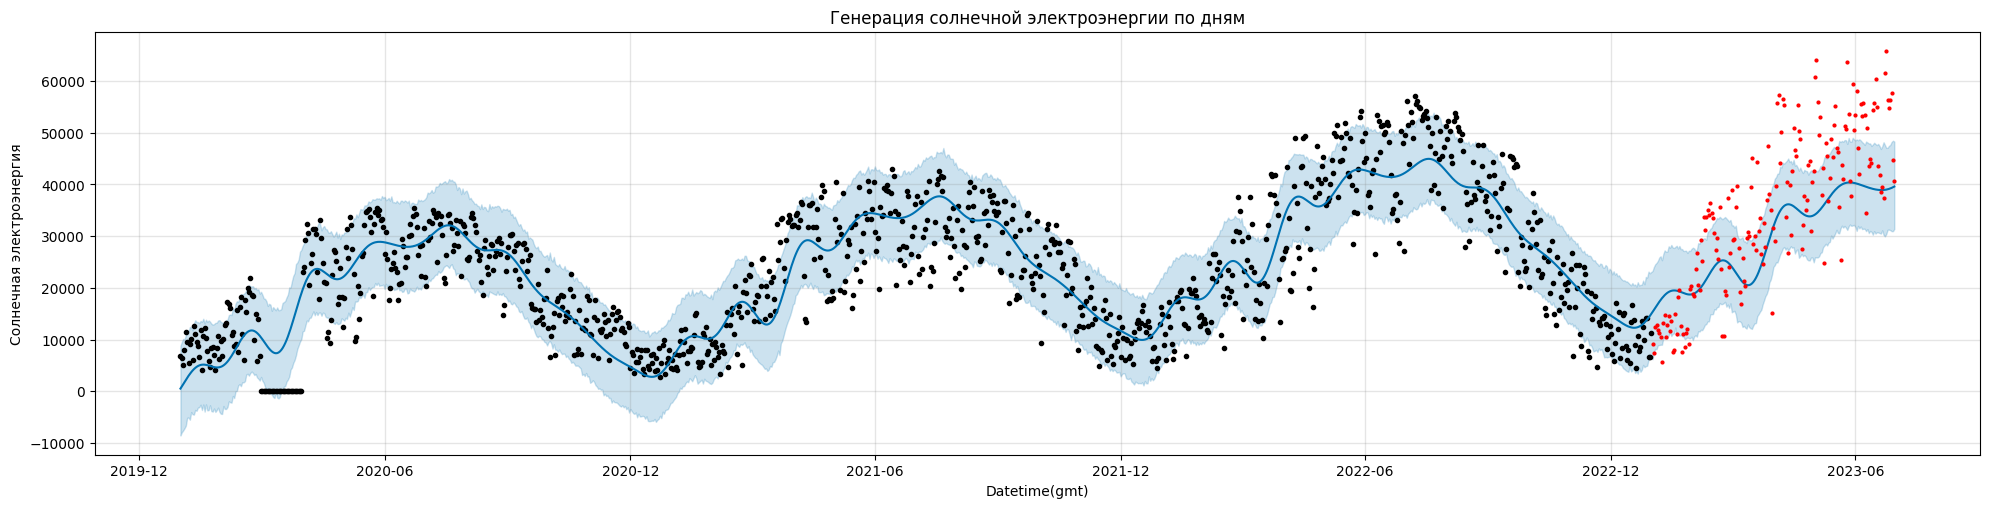

In [220]:
fig = model.plot(
    forecast, xlabel='Datetime(gmt)',
    ylabel=r'Солнечная электроэнергия',
    figsize=(20, 5), uncertainty=True)
plt.title('Генерация солнечной электроэнергии по дням')

ax = fig.gca()

# Добавим тестовые значения
ax.plot(
    solar_dy_day_test['ds'], solar_dy_day_test['y'], 'r.',
    label='Тестовые данные', markersize=4,
    zorder=1)

plt.show()

```plot_components``` построит графики всех доступных составляющих

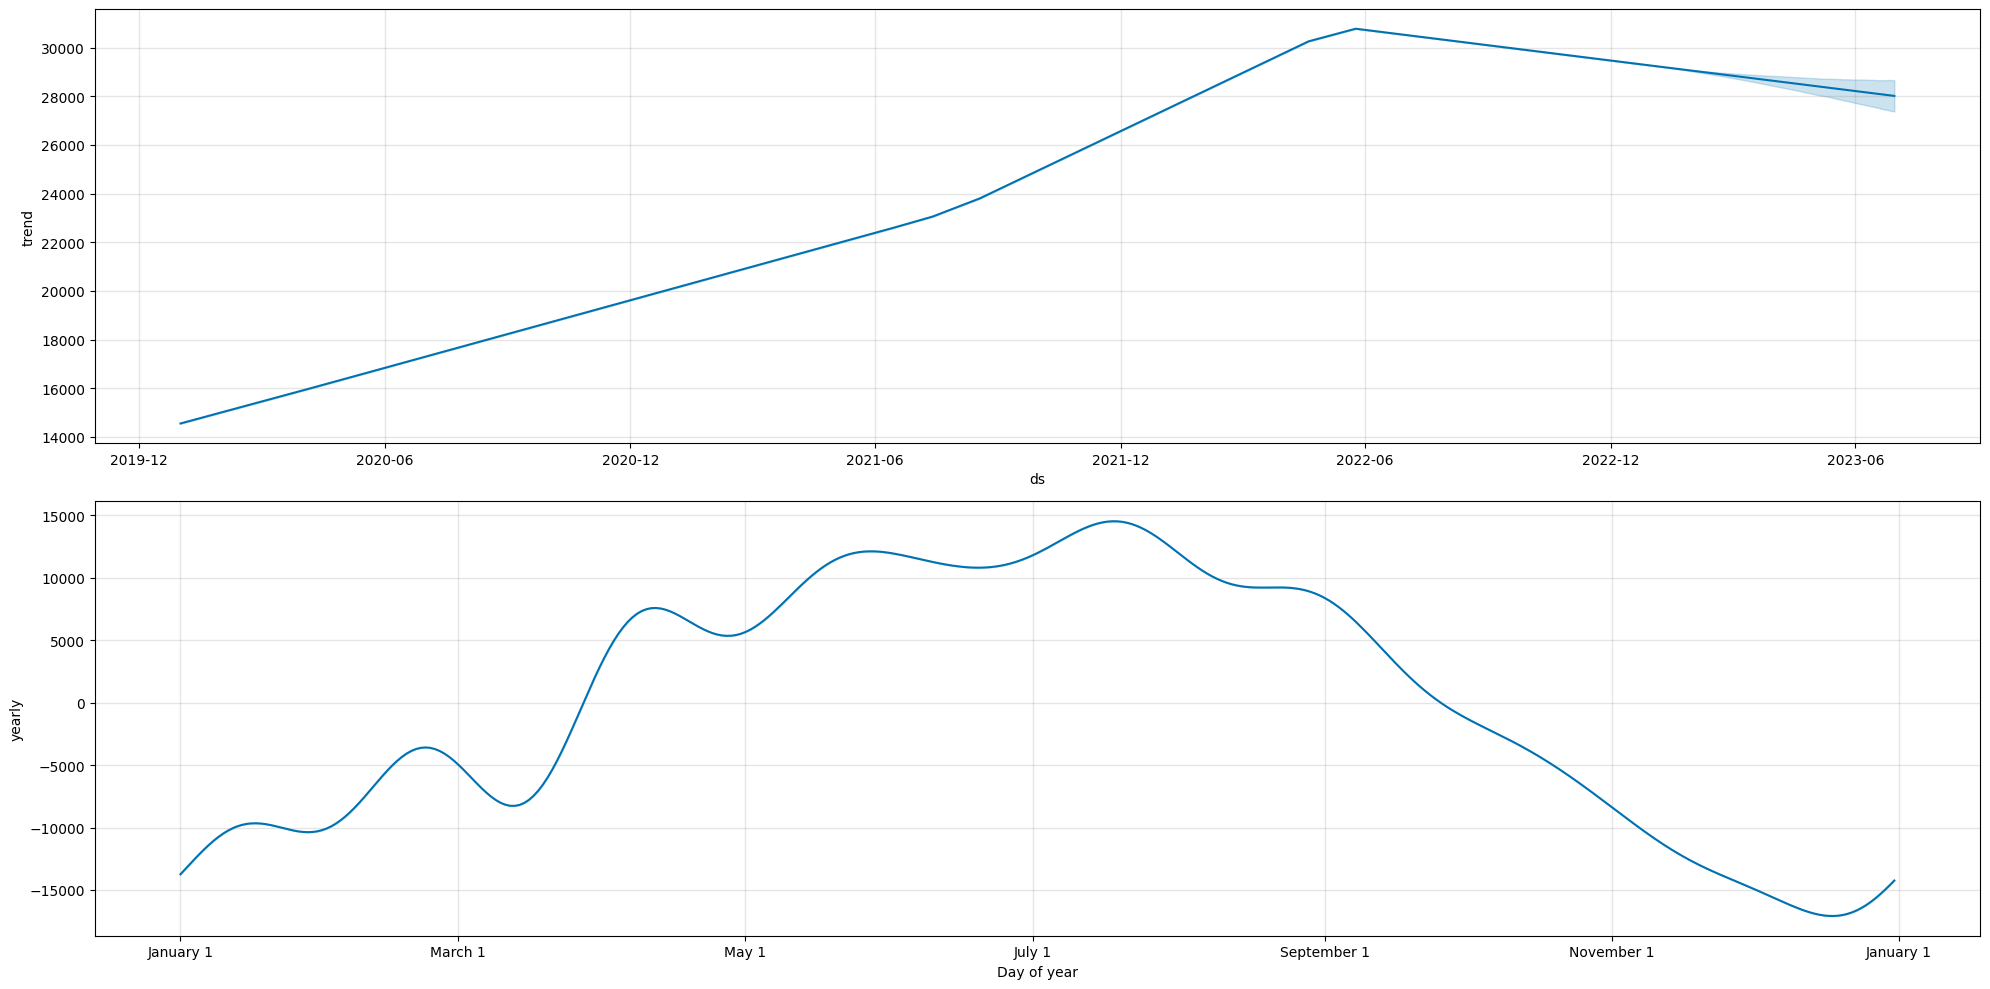

In [221]:
fig = model.plot_components(forecast,uncertainty=True,figsize=(20, 10))
plt.show()

Выполним расчет наиболее распространённых метрик

Обозначения:

- $ y_t $ — истинное значение в момент времени $ t $  
- $ \hat{y}_t $ — предсказанное значение  
- $ n $ — общее количество прогнозируемых точек

**MAE (Mean Absolute Error)**

Средняя абсолютная ошибка:

$$ \text{MAE} = \frac{1}{n} \sum_{t=1}^{n} |y_t - \hat{y}_t| $$

In [222]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(
    solar_dy_day_test['y'],
    forecast['yhat'][-solar_dy_day_test.shape[0]:]
)

baseline_mae = mean_absolute_error(
    solar_dy_day_test['y'],
    solar_dy_day_baseline_pred
)

print(f"MAE: {mae:.2f}")
print(f"Baseline MAE: {baseline_mae:.2f}")

MAE: 9024.55
Baseline MAE: 16000.07


**RMSE (Root Mean Squared Error)**

Корень из средней квадратичной ошибки:

$$ \text{RMSE} = \sqrt{\frac{1}{n} \sum_{t=1}^{n} (y_t - \hat{y}_t)^2} $$

In [223]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(
    solar_dy_day_test['y'],
    forecast['yhat'][-solar_dy_day_test.shape[0]:]
))

baseline_rmse = np.sqrt(mean_squared_error(
    solar_dy_day_test['y'],
    solar_dy_day_baseline_pred
))

print(f"RMSE: {rmse:.2f}")
print(f"Baseline RMSE: {baseline_rmse:.2f}")

RMSE: 11076.78
Baseline RMSE: 19028.98


**MAPE (Mean Absolute Percentage Error)**

Средняя абсолютная процентная ошибка:

$$ \text{MAPE} = \frac{100\%}{n} \sum_{t=1}^{n} \left| \frac{y_t - \hat{y}_t}{y_t} \right| $$

при $ y_t = 0 $ MAPE не определена (деление на ноль).

In [224]:
mape = np.mean(np.abs(
    (solar_dy_day_test['y'].values - forecast['yhat'][-solar_dy_day_test.shape[0]:].values) / solar_dy_day_test['y'].values)
) * 100

baseline_mape = np.mean(np.abs(
    (solar_dy_day_test['y'].values - solar_dy_day_baseline_pred) / solar_dy_day_test['y'].values)
) * 100

print(f"MAPE: {mape:.2f}%")
print(f"Baseline MAPE: {baseline_mape:.2f}%")

MAPE: 31.24%
Baseline MAPE: 51.29%


С точки зрения средней ошибки модель имеет очень низкое качество. Посмотрим на суммартные ошибки

**SAE (Sum of Absolute Errors)**

Суммарная абсолютная ошибка (без модуля):

$$ \text{SAE} = \sum_{t=1}^{n} (y_t - \hat{y}_t) $$


In [225]:
sae = np.sum(
    solar_dy_day_test['y'].values - forecast['yhat'][-solar_dy_day_test.shape[0]:].values)

baseline_sae = np.sum(
    solar_dy_day_test['y'].values - solar_dy_day_baseline_pred)

print(f"SAE: {sae:.2f}")
print(f"Baseline SAE: {baseline_sae:.2f}")

SAE: 966057.41
Baseline SAE: 2070502.28


**Ошибка доверительного интервала (Coverage )**

Lоля истинных значений, попавших в доверительный интервал прогноза

Если есть предсказания нижней и верхней границы интервала: $ \hat{y}_t^{\text{lower}}, \hat{y}_t^{\text{upper}} $, тогда:

$$ \text{Coverage} = \frac{1}{n} \sum_{t=1}^{n} \mathbb{1} \left[ \hat{y}_t^{\text{lower}} \leq y_t \leq \hat{y}_t^{\text{upper}} \right] $$

где $ \mathbb{1}[\cdot] $ — индикаторная функция (1, если условие выполнено, 0 иначе).

In [226]:
above_lower = solar_dy_day_test['y'].values >= forecast['yhat_lower'][-solar_dy_day_test.shape[0]:].values
below_upper = solar_dy_day_test['y'].values <= forecast['yhat_upper'][-solar_dy_day_test.shape[0]:].values
in_interval = above_lower & below_upper


coverage = in_interval.sum() / solar_dy_day_test.shape[0]
print(f"Покрытие: {coverage*100:.2f}%")

Покрытие: 53.04%


### Предсказание производства солнечной электроэнергии с учетом дневной сезонности

In [227]:
solar = pd.DataFrame(solar)
solar.columns = ["y"]
solar["ds"] = solar.index

In [228]:
solar.head()

,y,ds
DateTime,,
2020-01-01 00:00:00,0.0,2020-01-01 00:00:00
2020-01-01 01:00:00,0.0,2020-01-01 01:00:00
2020-01-01 02:00:00,0.0,2020-01-01 02:00:00
2020-01-01 03:00:00,0.0,2020-01-01 03:00:00
2020-01-01 04:00:00,0.0,2020-01-01 04:00:00


Разделим данные на обучающую и тестовую выборки

In [229]:
cutoff_date = '2023-01-01'

solar_train = solar[solar["ds"] < cutoff_date].copy()
solar_test = solar[solar["ds"] >= cutoff_date].copy()

print(f"Train: {solar_train.shape[0]} записей")
print(f"Test: {solar_test.shape[0]} записей")

Train: 25558 записей
Test: 4343 записей


Базовая модель

In [230]:
solar_baseline_pred = np.array(
    [solar_train['y'].mean() for _ in range(len(solar_test))])

Настройка и обучение модели предсказания

In [231]:
from prophet import Prophet

model_param ={
    "daily_seasonality": True, # ежедневная сезонность
    "weekly_seasonality":True, # недельная сезонность
    "yearly_seasonality":True, # годовая сезонность
    # "seasonality_mode": "multiplicative", # сезонность будет мультипликативной
    # "changepoint_prior_scale" : 0.05 # управляет гибкостью модели в определении изменений тренда
}

model = Prophet(**model_param)

model.fit(solar_train);

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdgriablh/ohfwk15n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdgriablh/fkf3nwrx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40407', 'data', 'file=/tmp/tmpdgriablh/ohfwk15n.json', 'init=/tmp/tmpdgriablh/fkf3nwrx.json', 'output', 'file=/tmp/tmpdgriablh/prophet_modelbz2u1ut_/prophet_model-20250408143224.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:32:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:32:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Получаем прогноз

In [232]:
future= model.make_future_dataframe(
    periods=solar_test.shape[0], # количество будущих временных шагов для прогноза
    freq='h' # частота временного ряда
)
forecast= model.predict(future)

### Анализ качества модели

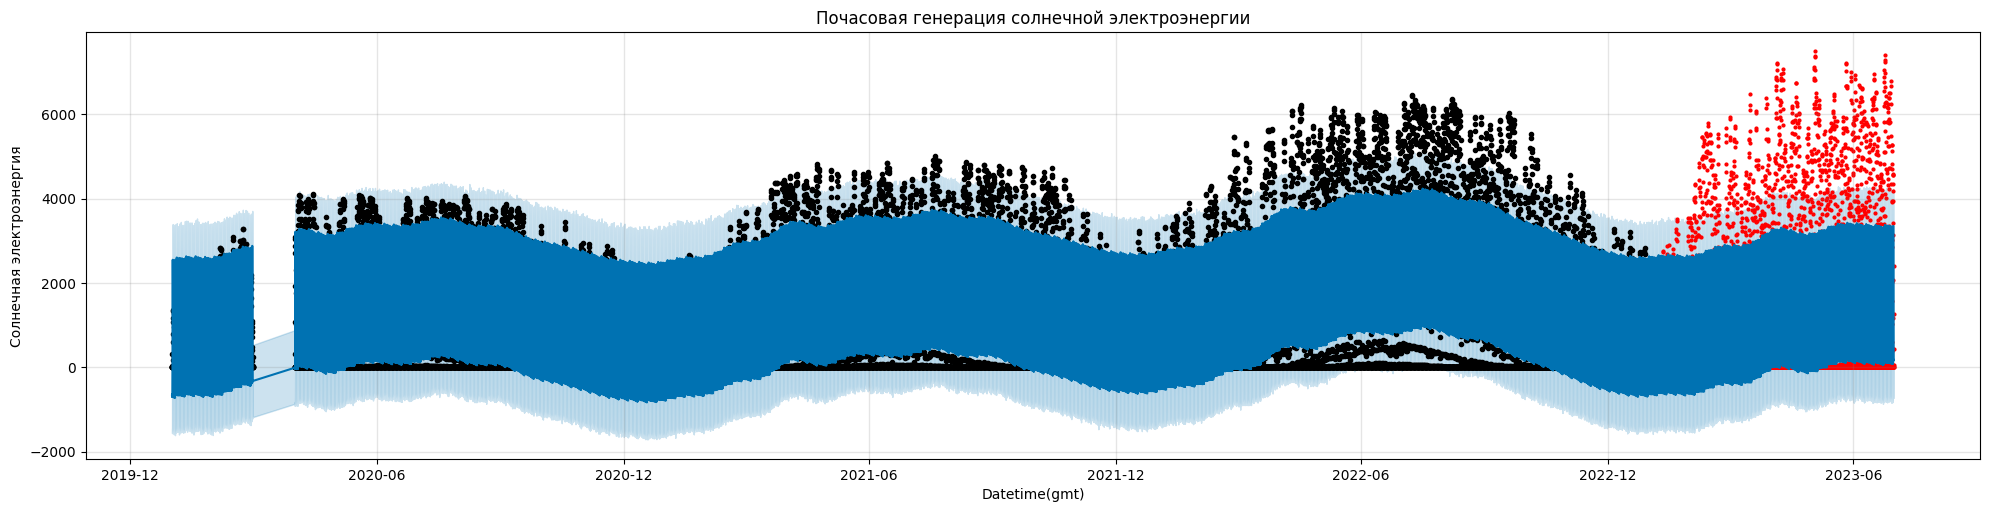

In [235]:
fig = model.plot(
    forecast, xlabel='Datetime(gmt)', ylabel=r'Солнечная электроэнергия', figsize=(20, 5), uncertainty=True)
plt.title('Почасовая генерация солнечной электроэнергии')

ax = fig.gca()

# Добавим тестовые значения
ax.plot(
    solar_test['ds'], solar_test['y'], 'r.',
    label='Тестовые данные', markersize=4,
    zorder=1)

plt.show()

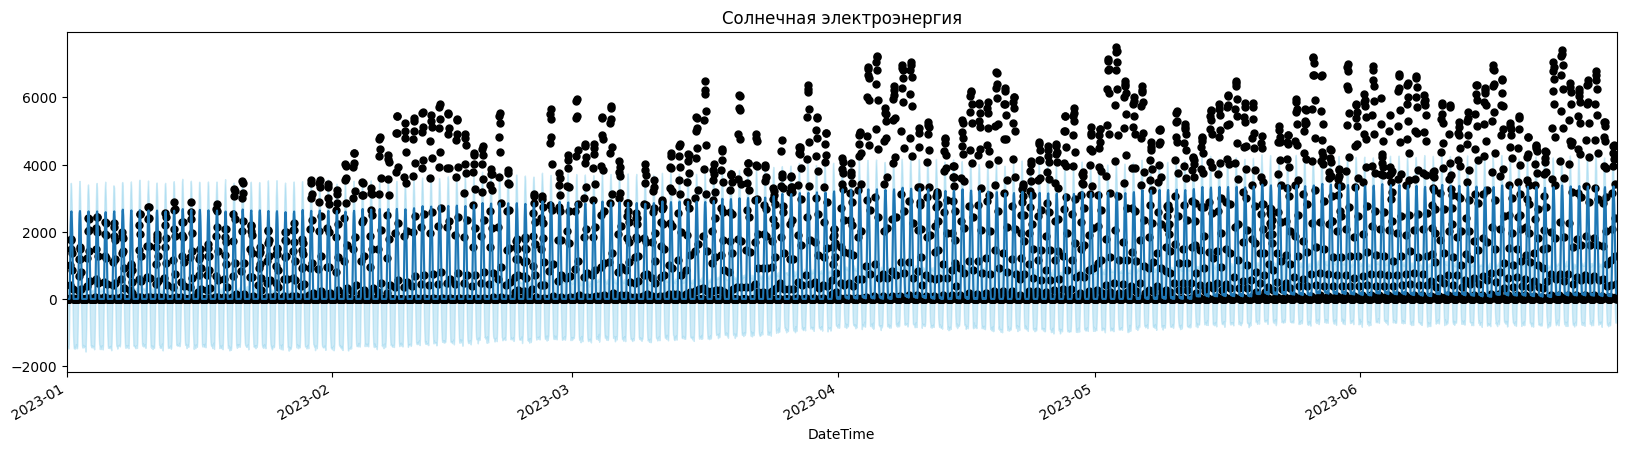

In [239]:
solar_test['y'].plot(
          style='.',
          figsize=(20, 5),
          ms=10,
          color="black",
          title='Солнечная электроэнергия');

plt.plot(
    solar_test.index,
    forecast['yhat'][-solar_test.shape[0]:].clip(lower=0));

plt.fill_between(
    forecast['ds'],
    forecast['yhat_lower'],
    forecast['yhat_upper'],
    color='skyblue',
    alpha=0.4, label='Доверительный интервал (80%)');

plt.xlim(pd.to_datetime([solar_test.index[0], solar_test.index[-1]]));

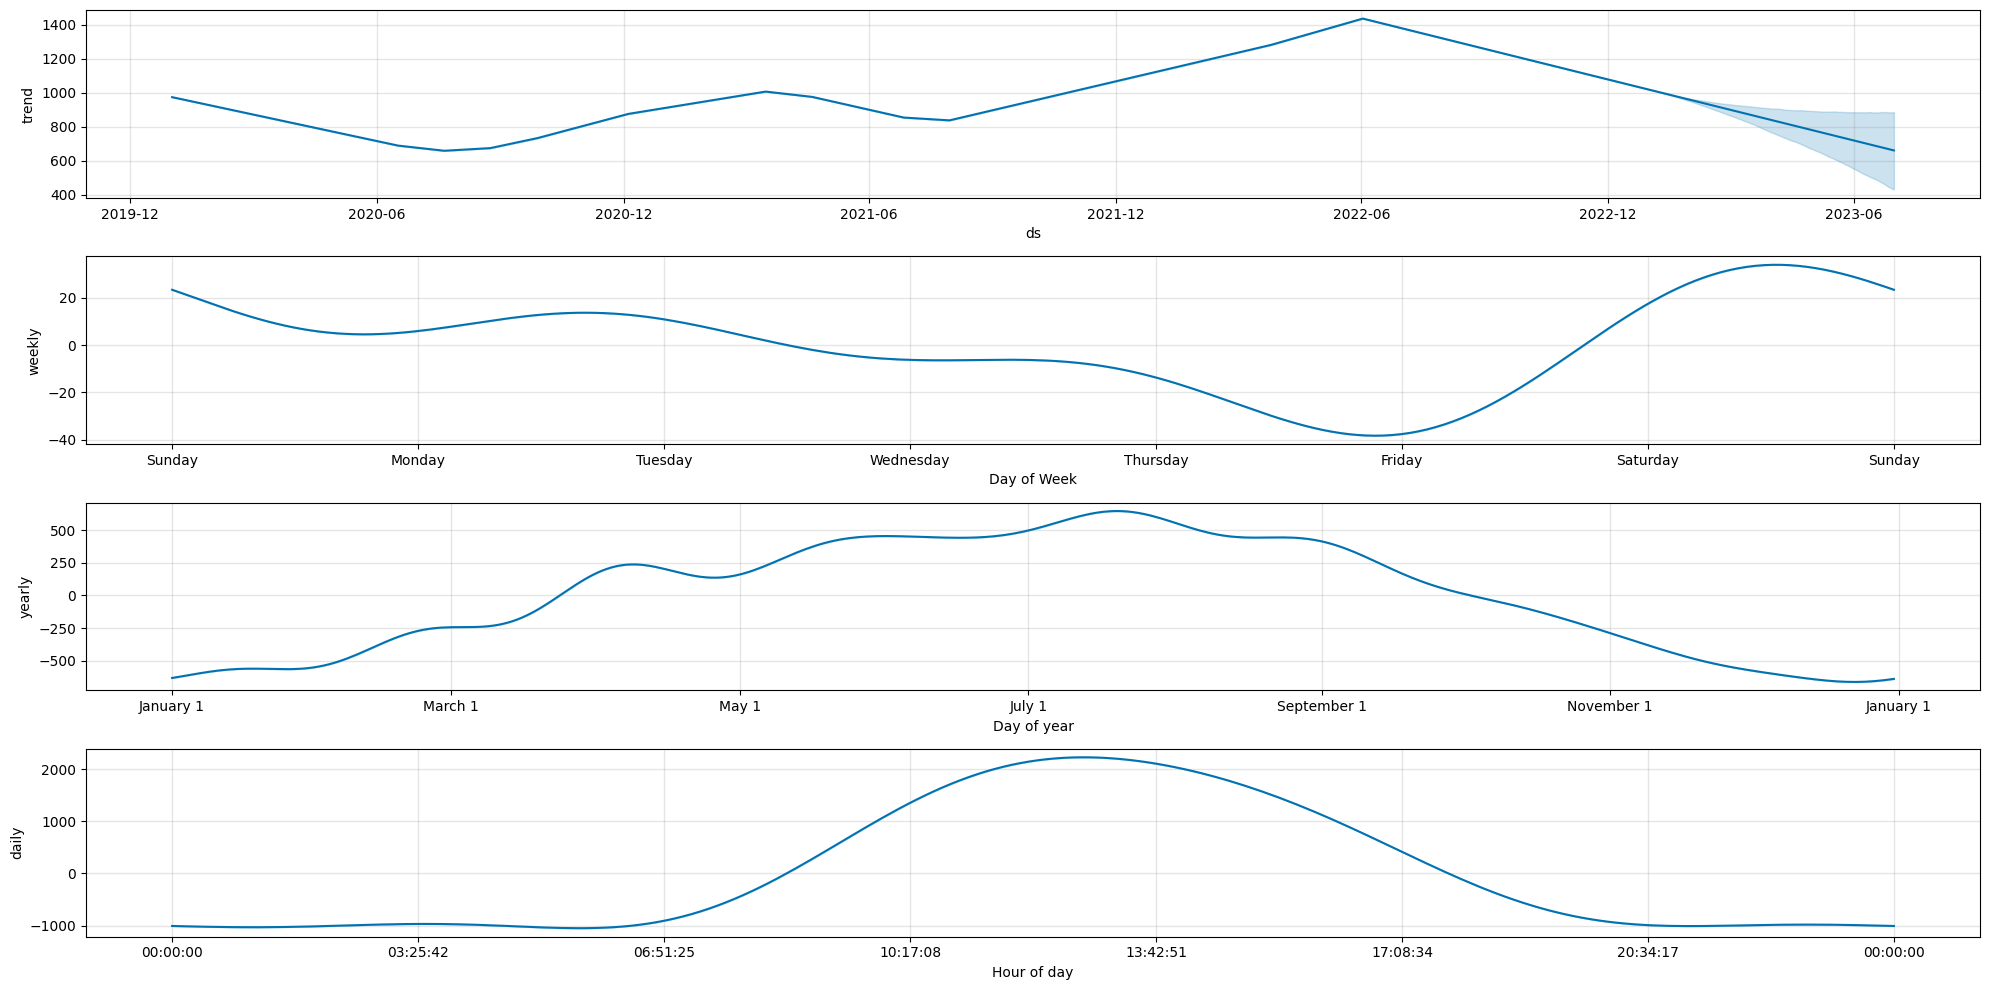

In [240]:
fig = model.plot_components(forecast,uncertainty=True,figsize=(20, 10))
plt.show()

**MAE (Mean Absolute Error)**

Средняя абсолютная ошибка:

In [241]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(
    solar_test['y'],
    forecast['yhat'][-solar_test.shape[0]:].clip(lower=1e-6)
)

baseline_mae = mean_absolute_error(
    solar_test['y'],
    solar_baseline_pred
)

print(f"MAE: {mae:.2f}")
print(f"Baseline MAE: {baseline_mae:.2f}")

MAE: 683.65
Baseline MAE: 1561.15


**RMSE (Root Mean Squared Error)**

Корень из средней квадратичной ошибки:

In [242]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(
    solar_test['y'],
    forecast['yhat'][-solar_test.shape[0]:].clip(lower=0)
))

baseline_rmse = np.sqrt(mean_squared_error(
    solar_test['y'],
    solar_baseline_pred
))

print(f"RMSE: {rmse:.2f}")
print(f"Baseline RMSE: {baseline_rmse:.2f}")

RMSE: 1200.07
Baseline RMSE: 2027.34


**MAPE (Mean Absolute Percentage Error)**

Средняя абсолютная процентная ошибка:

In [243]:
mape = np.mean(np.abs(
    (solar_test['y'].values - forecast['yhat'][-solar_test.shape[0]:].clip(lower=0).values) / solar_test['y'].clip(lower=1e-6).values)
) * 100

baseline_mape = np.mean(np.abs(
    (solar_test['y'].clip(lower=1e-6).values - solar_baseline_pred) / solar_test['y'].clip(lower=1e-6).values)
) * 100

print(f"MAPE: {mape:.2f}%")
print(f"Baseline MAPE: {baseline_mape:.2f}%")

MAPE: 723072372.25%
Baseline MAPE: 14952965745.98%


**SAE**

Суммарная абсолютная ошибка (без модуля):

In [244]:
sae = np.sum(
    solar_test['y'].values - forecast['yhat'][-solar_test.shape[0]:].clip(lower=0).values)

baseline_sae = np.sum(
    solar_test['y'].values - solar_baseline_pred)

print(f"SAE: {sae:.2f}")
print(f"Baseline SAE: {baseline_sae:.2f}")

SAE: 2247649.23
Baseline SAE: 1947848.91


**Ошибка доверительного интервала**

In [245]:
above_lower = solar_test['y'].values >= forecast['yhat_lower'][-solar_test.shape[0]:].values
below_upper = solar_test['y'].values <= forecast['yhat_upper'][-solar_test.shape[0]:].values
in_interval = above_lower & below_upper


coverage = in_interval.sum() / solar_test.shape[0]
print(f"Покрытие: {coverage*100:.2f}%")

Покрытие: 71.72%


## Производство ветряной электроэнергии
### Разложение временного ряда

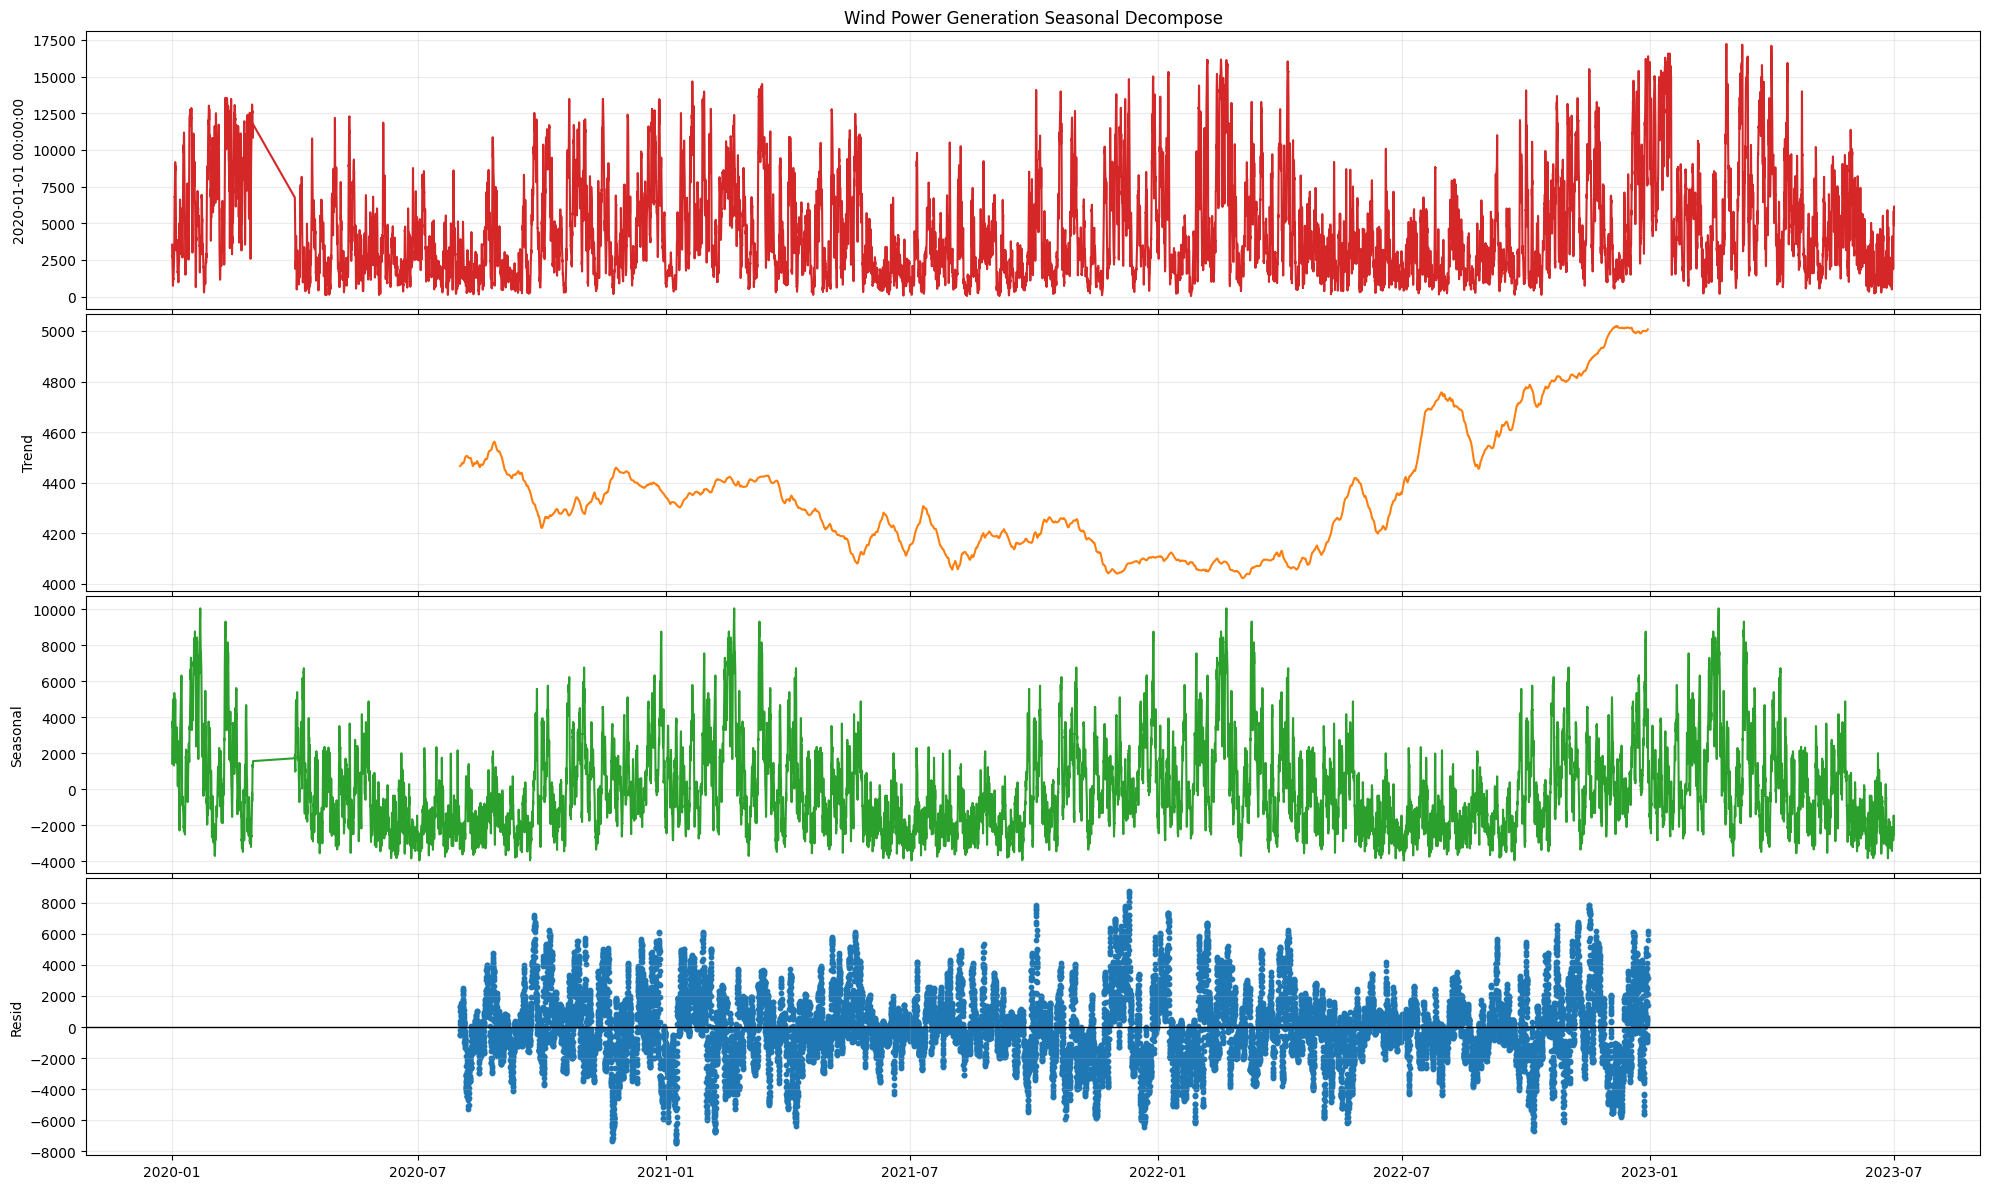

In [246]:
_ = seasonal_decompose_plotter(wind, period=365*24, title='Wind Power Generation Seasonal Decompose', figsize=(20, 12))

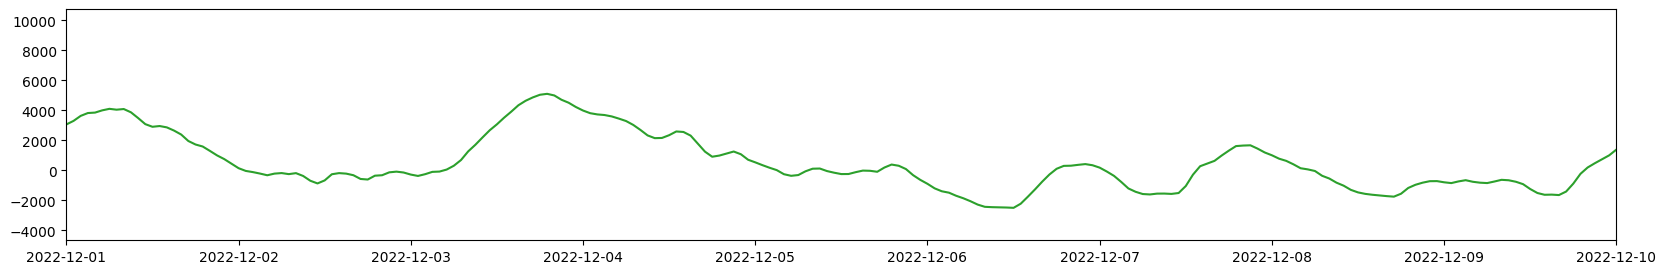

In [247]:
fig = plt.figure(figsize=(20, 3));
plt.plot(wind.index, _.seasonal, color='C2');
plt.xlim(pd.to_datetime(['2022-12-01', '2022-12-10']));

### Предсказание производства ветряной электроэнергии

In [248]:
wind = pd.DataFrame(wind)
wind.columns = ["y"]
wind["ds"] = wind.index

Разделим данные на обучающую и тестовую выборки

In [249]:
cutoff_date = '2023-01-01'

wind_train = wind[wind["ds"] < cutoff_date].copy()
wind_test = wind[wind["ds"] >= cutoff_date].copy()

print(f"Train: {wind_train.shape[0]} записей")
print(f"Test: {wind_test.shape[0]} записей")

Train: 25560 записей
Test: 4343 записей


Базовая модель

In [250]:
wind_baseline_pred = np.array(
    [wind_train['y'].mean() for _ in range(len(wind_test))])

Настройка и обучение модели предсказания

In [251]:
model_param ={
    "daily_seasonality": False,
    "weekly_seasonality":False,
    "yearly_seasonality":True,
    # "seasonality_mode": "multiplicative",
    # "changepoint_prior_scale" : 0.5
}

model = Prophet(**model_param)
model.fit(wind_train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdgriablh/fjh3n5en.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdgriablh/x2lbiuie.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84558', 'data', 'file=/tmp/tmpdgriablh/fjh3n5en.json', 'init=/tmp/tmpdgriablh/x2lbiuie.json', 'output', 'file=/tmp/tmpdgriablh/prophet_modelxudoyv1v/prophet_model-20250408143836.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:38:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:38:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Получаем прогноз

In [252]:
# Create future dataframe
future= model.make_future_dataframe(periods=wind_test.shape[0] ,freq='h')
forecast= model.predict(future)

### Анализ качества модели

Observed data points
Forecast


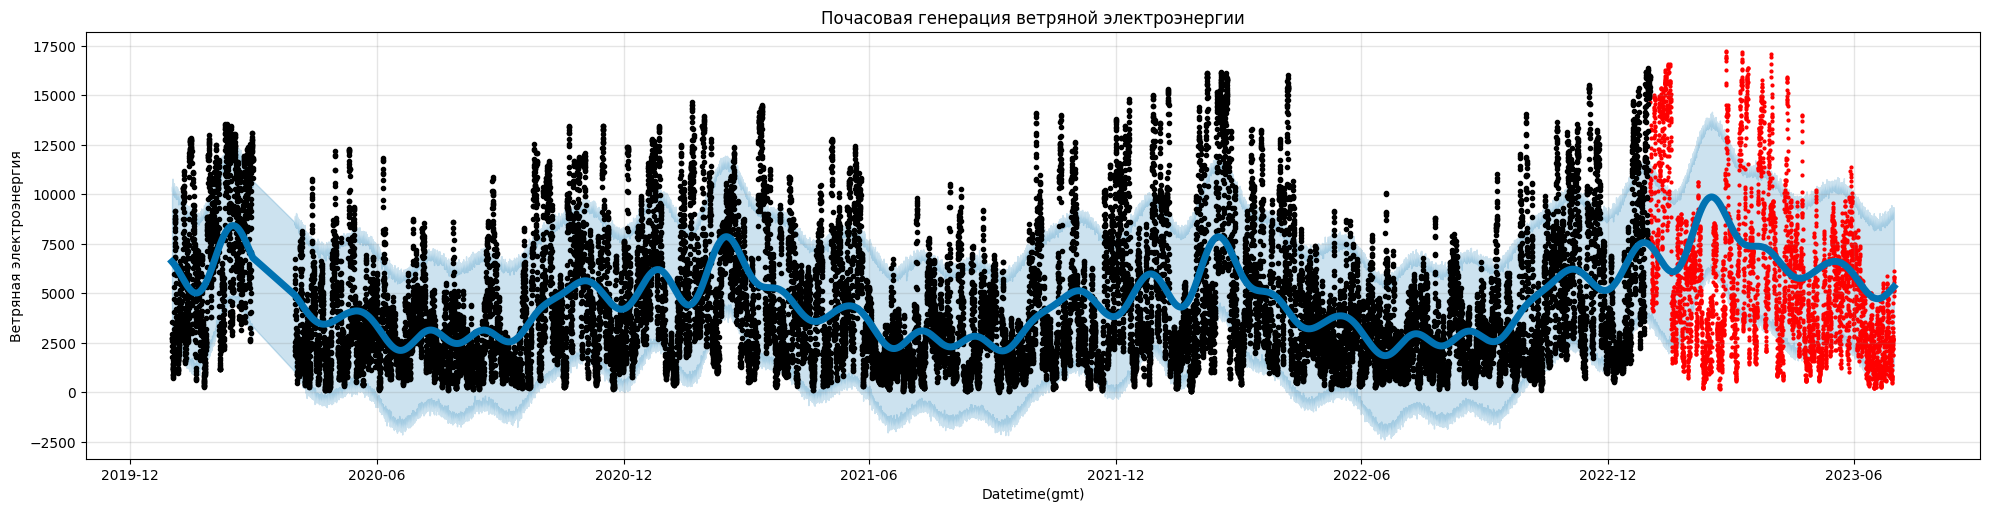

In [256]:
fig = model.plot(
    forecast, xlabel='Datetime(gmt)',
    ylabel=r'Ветряная электроэнергия', figsize=(20, 5), uncertainty=True)

ax = fig.gca()

# Увеличиваем толщину линии прогноза (она всегда синяя по умолчанию):
for line in ax.get_lines():
    print(line.get_label())
    if line.get_label() == 'Forecast':
        line.set_linewidth(5)

# Добавим тестовые значения
ax.plot(
    wind_test['ds'], wind_test['y'], 'r.',
    label='Тестовые данные', markersize=4,
    zorder=1)

plt.title('Почасовая генерация ветряной электроэнергии')
plt.show()

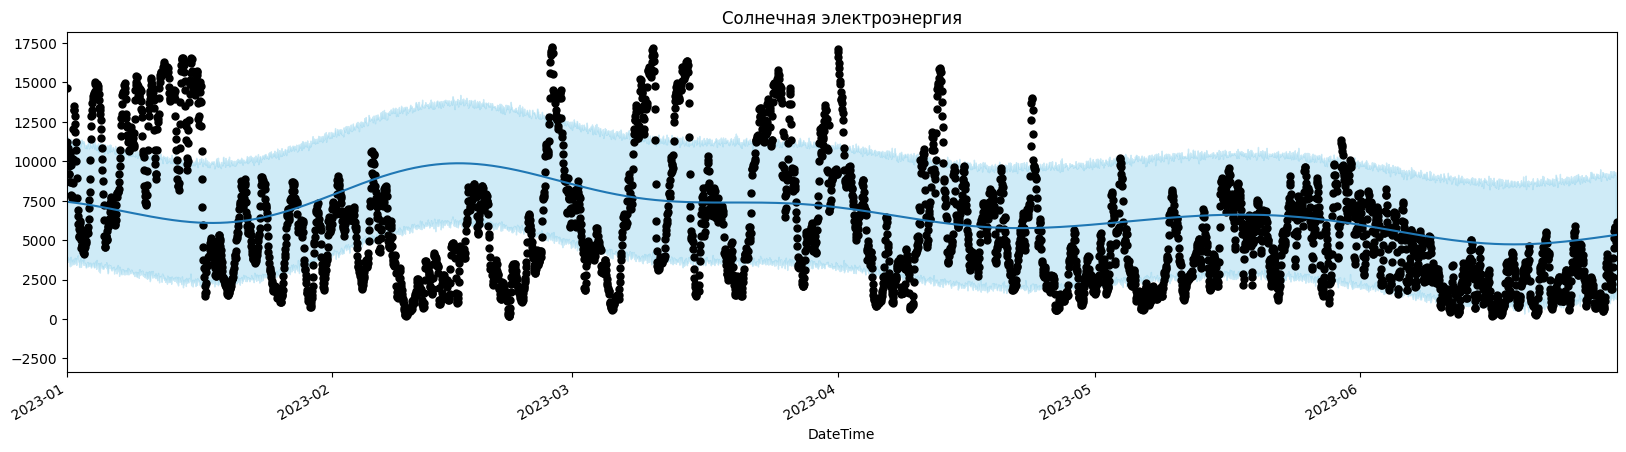

In [257]:
wind_test['y'].plot(
          style='.',
          figsize=(20, 5),
          ms=10,
          color="black",
          title='Солнечная электроэнергия');

plt.plot(
    wind_test.index,
    forecast['yhat'][-solar_test.shape[0]:].clip(lower=0));

plt.fill_between(
    forecast['ds'],
    forecast['yhat_lower'],
    forecast['yhat_upper'],
    color='skyblue',
    alpha=0.4, label='Доверительный интервал (80%)');

plt.xlim(pd.to_datetime([wind_test.index[0], wind_test.index[-1]]));

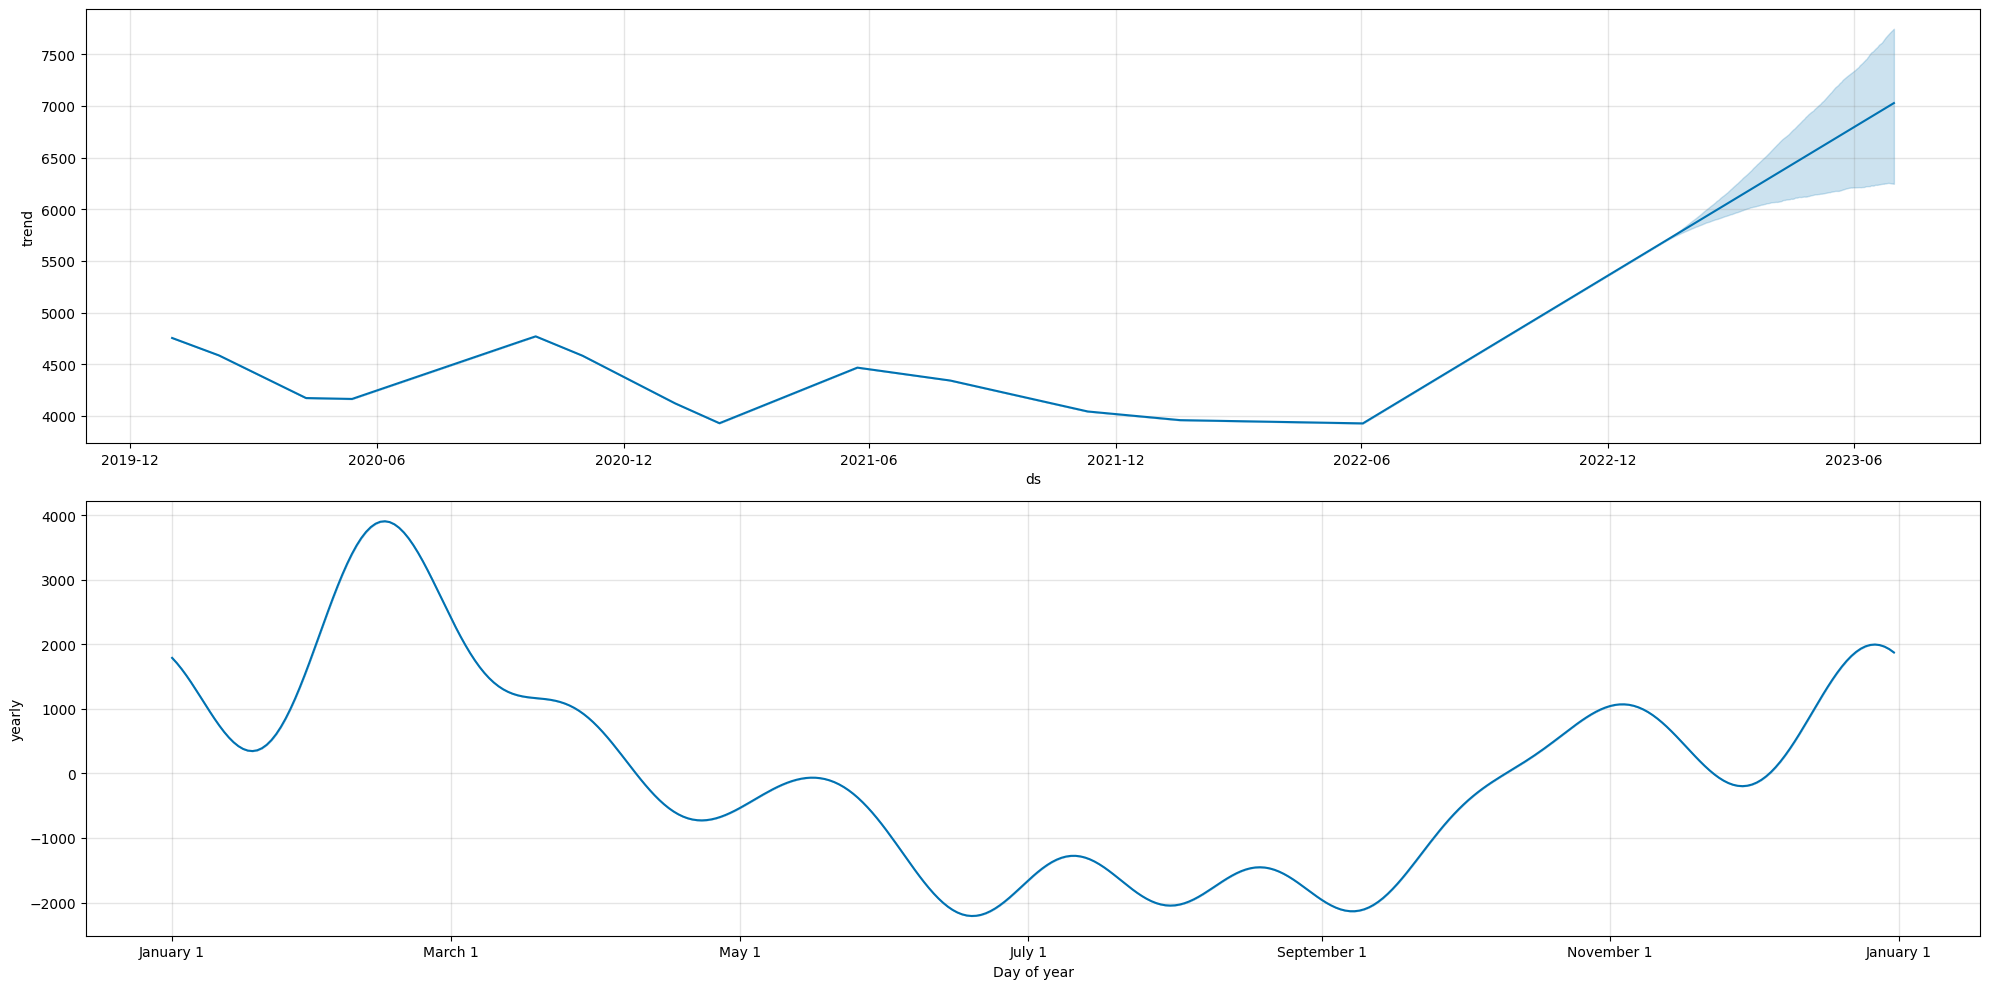

In [258]:
fig = model.plot_components(forecast,uncertainty=True,figsize=(20, 10))
plt.show()

**MAE (Mean Absolute Error)**

Средняя абсолютная ошибка:

In [259]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(
    wind_test['y'],
    forecast['yhat'][-wind_test.shape[0]:].clip(lower=1e-6)
)

baseline_mae = mean_absolute_error(
    wind_test['y'],
    wind_baseline_pred
)

print(f"MAE: {mae:.2f}")
print(f"Baseline MAE: {baseline_mae:.2f}")

MAE: 3394.51
Baseline MAE: 3087.16


**RMSE (Root Mean Squared Error)**

Корень из средней квадратичной ошибки:

In [260]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(
    wind_test['y'],
    forecast['yhat'][-wind_test.shape[0]:].clip(lower=0)
))

baseline_rmse = np.sqrt(mean_squared_error(
    wind_test['y'],
    wind_baseline_pred
))

print(f"RMSE: {rmse:.2f}")
print(f"Baseline RMSE: {baseline_rmse:.2f}")

RMSE: 4144.53
Baseline RMSE: 4165.48


**MAPE (Mean Absolute Percentage Error)**

Средняя абсолютная процентная ошибка:

In [261]:
mape = np.mean(np.abs(
    (wind_test['y'].values - forecast['yhat'][-wind_test.shape[0]:].values) / wind_test['y'].values)
) * 100

baseline_mape = np.mean(np.abs(
    (wind_test['y'].values - wind_baseline_pred) / wind_test['y'].values)
) * 100

print(f"MAPE: {mape:.2f}%")
print(f"Baseline MAPE: {baseline_mape:.2f}%")

MAPE: 143.44%
Baseline MAPE: 90.16%


**SAE**

Суммарная абсолютная ошибка (без модуля):

In [262]:
sae = np.sum(
    wind_test['y'].values - forecast['yhat'][-wind_test.shape[0]:].clip(lower=0).values)

baseline_sae = np.sum(
    wind_test['y'].values - wind_baseline_pred)

print(f"SAE: {sae:.2f}")
print(f"Baseline SAE: {baseline_sae:.2f}")

SAE: -4946399.46
Baseline SAE: 5954298.09


**Ошибка доверительного интервала**

In [263]:
above_lower = wind_test['y'].values >= forecast['yhat_lower'][-wind_test.shape[0]:].values
below_upper = wind_test['y'].values <= forecast['yhat_upper'][-wind_test.shape[0]:].values
in_interval = above_lower & below_upper


coverage = in_interval.sum() / wind_test.shape[0]
print(f"Покрытие: {coverage*100:.2f}%")

Покрытие: 61.73%
